# Análise de sentimenos usando NLP

- O seguinte projeto tem como objetivo criar um modelo NLP classificador para analisar o humor dos usuários baseados em seus dados (tweets);
- A plataforma escolhida para essa atividade foi o X (Twitter), por meio do dataset público sentiment140 disponível no Kaggle;

# Equipe:
- Pedro Yutaro Mont Morency Nakamura;
- Lucas Carvalho dos Santos;
- Caio Jorge Da Cunha Queiroz;
- Lucas Maciel Gomes;

# 1 - Importação de bibliotecas
Inicialmente iremos importar as seguintes bibliotecas:
- *Pandas + Numnpy*: Manipulação de dados;
- *Scikit-learn*: Pré-processamento e criação de métricas do modelo;
- *NLTK*: Biblioteca para pre-processamento de texto humano (toolkit de linguagem natural);
- *matplotlib*: Criação de gráficos para a vizualização dos resultados;

In [84]:
# Analise e tratamento de dados
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
# Processamento de linguagem natural
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# Bibliotecas para o classificador
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# 2 - Tratando o dataset

O Conteudo do dataset contem os seguintes campos:

1. target: polaridade do tweet (0 = negative, 2 = neutral, 4 = positive)
2. ids: o ID do tweet (ex: 2089)
3. date: A data do tweet (ex: Sat May 16 23:58:44 UTC 2009)
4. flag: A query (ex: lyx). Se não há nenhuma query, por padrão o valor é "NO_QUERY".
5. user: O usuário que twittou (ex: robotickilldozr)
6. text: o conteúdo do tweet (ex: Lyx is cool)

Porem, por padrão as colunas do dataset vem sem esses identificadores, abaixo iremos arrumar isso:

In [57]:
# Carregando o dataset do keagle
df = pd.read_csv("tweets_data.csv", encoding="latin-1", header=None)
# Renomeando colunas conforme a documentação
df.columns = ["target", "id", "date", "flag", "user", "text"]
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Para que não haja duplicidade de conteúdo, seria interessante verificarmos se há tweets duplicados e remove-los do nosso dataset:

In [58]:
def show_amount_dup(data):
    dup = round(sum(data.duplicated("id")/len(data)*100), 3)
    print(f"Percentual de tweets duplicados: {dup}%")

show_amount_dup(df)

Percentual de tweets duplicados: 0.105%


In [60]:
# removendo tweets duplicados
df.drop_duplicates("id", inplace=True)
show_amount_dup(df)

Percentual de tweets duplicados: 0.0%


Com a duplicidade de informações já excluidas, agora podemos otimizar a nossa base de dados para usarmos apenas as informações uteis para o treinamento

In [86]:
# Iremos usar apenas essas colunas em nosso treino
df = df[["target", "text"]]
# Ajustar as categorias
df["sentiment"] = df["target"].map({0: "negativo", 2: "neutro", 4: "positivo"})
df.head()

,target,text,sentiment
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",negativo
1,0,is upset that he can't update his Facebook by ...,negativo
2,0,@Kenichan I dived many times for the ball. Man...,negativo
3,0,my whole body feels itchy and like its on fire,negativo
4,0,"@nationwideclass no, it's not behaving at all....",negativo


# 3 - Pré-processamento de dados

Como é possível observar, agora o nosso dataframe possui apenas a polaridade, o texto e o sentimento correspondente

Porém é possível que parte desse texto contenha "ruídos" como URLs, menções, emojis ou símbolos especiais. Para isso, iremos fazer uma breve limpeza usando nltk para lidar com stopwords:

In [87]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Com o dataset ja otimizado e as dependencias baixadas, podemos realizar o pre-processamento no dataset

In [88]:
stop_words = set(stopwords.words("english"))

reURL = r"http\S+|www\S+|https\S+"
reMention = r"@\w+"
reSpecChars_and_Nums = r"[^A-Za-z\s]"

def preprocess_text(txt):
    # remove urls
    txt = re.sub(reURL, "", txt)
    txt = re.sub(reMention, "", txt)
    txt = re.sub(reSpecChars_and_Nums, "", txt))
    # tokenizar e remover stop words
    tokens = word_tokenize(txt.lower())
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

SyntaxError: unmatched ')' (2939092108.py, line 11)

In [89]:
df["text"] = df["text"].apply(preprocess_text)

# 4 - Divisão dos dados
Com os dados ja tratados, iremos dividi-los em dados de treino e teste:

In [90]:
X = df["text"]
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {len(X_train)}\nTest: {len(X_test)}")

Train: 1278652
Test: 319663


# 5. Vetorizando o texo usando TF-IDF

_"Ah mas porque usar logo o TF-IDF?"_

Sim, poderiamos ter usado BoW para essa etapa, porem TF-IDF é bom para lidar com relevância das palavras, uma vez que a relevância é ajustada ao penalizar palavras que aparecem com frequência (stop words), dando mais peso para palavras específicas (diferente do bow que apenas considera frequência bruta de uma palavra no texto, dando pesos desnecessários para palavras que são irrelevantes para o SENTIMENTO).

In [91]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # limitar a 5k features
# ajustar ao conjunto de treino
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# transformar o conjunto de teste
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 5.1 Vetorizando o texto usando BoW

In [92]:
bow_vectorizer = CountVectorizer(max_features=5000) # limitar a 5k features
# ajustar ao conjunto de treino
X_train_bow = bow_vectorizer.fit_transform(X_train)
# transformar o conjunto de teste
X_test_bow = bow_vectorizer.transform(X_test)

# 6. Treinando ambos modelos
Aqui usaremos Regressão Logistica para treinar o classificador

In [93]:
model = LogisticRegression()
model_bow = model.fit(X_train_bow, y_train)
model_tfdif = model.fit(X_train_tfidf, y_train)

# 7 - Vizualização das métricas

Metricas do BoW:

In [94]:
# Fazer previsões no conjunto de teste
y_pred_bow = model_bow.predict(X_test_bow)

# Exibir relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_bow))

# Exibir a matriz de confusão
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_bow))

# Exibir a acurácia geral
print(f"Acurácia: {accuracy_score(y_test, y_pred_bow):.3f}")

Relatório de Classificação:
              precision    recall  f1-score   support

    negativo       0.75      0.81      0.78    159435
    positivo       0.79      0.73      0.76    160228

    accuracy                           0.77    319663
   macro avg       0.77      0.77      0.77    319663
weighted avg       0.77      0.77      0.77    319663

Matriz de Confusão:
[[128573  30862]
 [ 42711 117517]]
Acurácia: 0.770


Metricas do TF-DIF:

In [95]:
# Fazer previsões no conjunto de teste
y_pred_tfdif = model_bow.predict(X_test_tfidf)

# Exibir relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred_tfdif))

# Exibir a matriz de confusão
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_tfdif))

# Exibir a acurácia geral
print(f"Acurácia: {accuracy_score(y_test, y_pred_tfdif):.3f}")

Relatório de Classificação:
              precision    recall  f1-score   support

    negativo       0.79      0.75      0.77    159435
    positivo       0.76      0.80      0.78    160228

    accuracy                           0.77    319663
   macro avg       0.78      0.77      0.77    319663
weighted avg       0.78      0.77      0.77    319663

Matriz de Confusão:
[[120046  39389]
 [ 32608 127620]]
Acurácia: 0.775


Aqui iremos por fim gerar a matriz de confusão para cada um dos modelos:

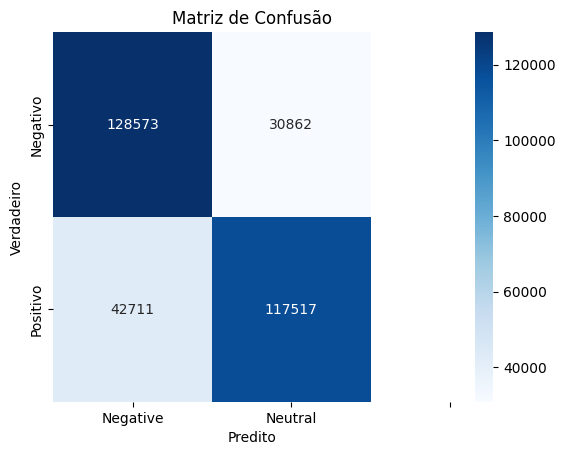

In [97]:
# Criar matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_bow)

# Plotar usando Seaborn
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", ""], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

Testando novas Predições

In [45]:
def test_prediction(txt):
    vectorized_txt = tfidf_vectorizer.transform([txt])
    pred = model.predict(vectorized_txt)
    print(pred)

In [50]:
test_prediction("i really hate this new brand outfit")

['negativo']


In [53]:
test_prediction("i don't like the way that this gun works, looks really mediocry")

['positivo']
